### Clip a satellite image to AOI and reproject into a new CRS

In [17]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

In [7]:
img_url = 'data/20190321_174348_0f1a_3B_AnalyticMS.tif'
img = rasterio.open(img_url)

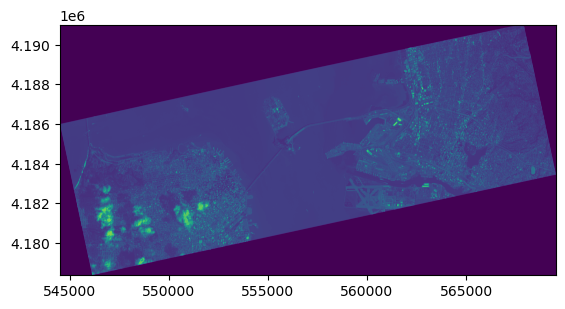

<AxesSubplot: >

In [30]:
show((img, 2))

#### Using a mask to cut a raster

In [31]:
import fiona

In [32]:
with fiona.open('data/aoi.geojson') as geojson:
    aoi = [feature['geometry'] for feature in geojson]

In [33]:
from rasterio.mask import mask

# apply as mask with crop=True to crop the resulting raster
# to the AOI's bounding box
with rasterio.open(img_url) as img:
    clipped, transform = mask(img, aoi, crop=True)

print(clipped.shape)

(4, 2308, 3375)


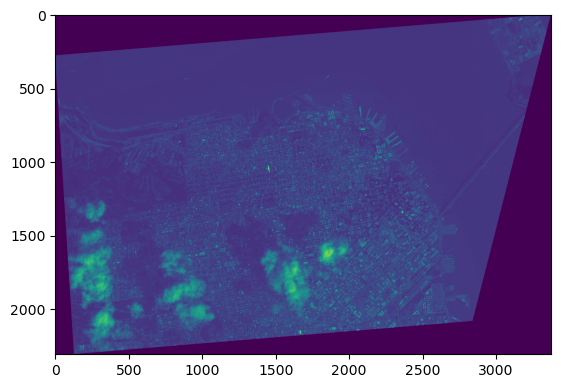

In [51]:
plt.imshow(clipped[0, :])

In [53]:
meta = img.meta.copy()
meta.update({'transform': transform, 'width': clipped.shape[1], 'height': clipped.shape[2]})
with rasterio.open('output/clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)

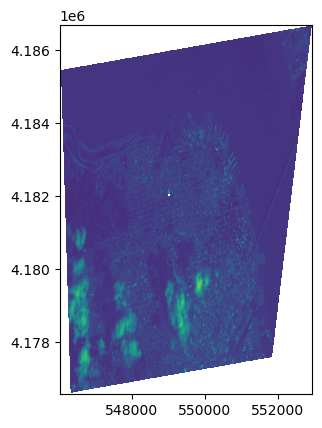

<AxesSubplot: >

In [62]:
dst = rasterio.open('output/clipped.tif')
show(dst)

### Reprojecting a Raster

In [63]:
from rasterio.warp import calculate_default_transform, reproject

In [76]:
print(dst.crs.data)

{'init': 'epsg:32610'}


In [74]:
# calculate the transform based on the source and destination crs and the original raster metadata properties
target_crs = 'EPSG:4326'
left, bottom, right, top = dst.bounds
bounds = dict(left=left, bottom=bottom, right=right, top=top)
transform, width, height = calculate_default_transform(
    src_crs=dst.crs.data, dst_crs=target_crs, width=dst.width, height=dst.height, **bounds
)

In [75]:
# copy and update the metadata for the new raster
metadata = dst.meta.copy()
metadata.update({
    'crs':  target_crs,
    'transform': transform,
    'width': width,
    'height': height
})

In [78]:
# reproject each band from the source dataset and store into the new dataset
# the reprojection uses the transform data previously obtained 
with rasterio.open('output/clipped_reprojected_4326.tif', 'w', **metadata) as reprojected:
    for band in range(1, dst.count + 1):
        reproject(
            source=rasterio.band(dst, band),
            destination=rasterio.band(reprojected, band),
            src_transform=dst.transform,
            src_crs=dst.crs,
            dst_transform=transform,
            dst_crs=target_crs
        )

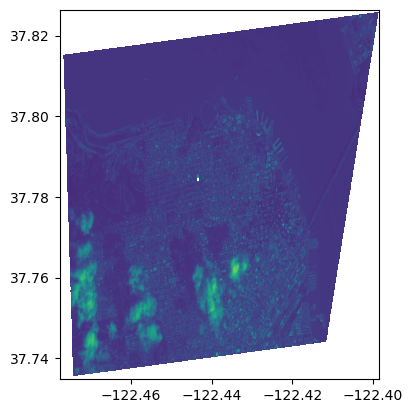

<AxesSubplot: >

In [79]:
reproj = rasterio.open('output/clipped_reprojected_4326.tif')
show(reproj)